# Single-Cell Genomics

In this example notebook, we show how to use PyMDE to compute an embedding of some single-cell genomics data.

We'll embed roughly 44,000 PBMCs, specified by their mRNA transcriptomes, into 3 dimensions. These PBMCs were collected from some patients who were healthy, and others who had severe COVID-19 infections.

After embedding, we'll plot the embedding and analyze it by coloring the vectors by cell type and patient health status. We'll also analyze where the embedding succeeded, and where it failed.


In [1]:
import pymde

### The original data
The data is from [A single-cell atlas of the peripheral immune response in patients with severe COVID-19](https://www.nature.com/articles/s41591-020-0944-y), by Wilk, et al (2020).

The original data is available at https://cellxgene.cziscience.com/

In [2]:
scrna_wilk = pymde.datasets.covid19_scrna_wilk()

Feb 04 08:57:18 AM: Load cached dataset.


The data is a matrix in which each row is a PCA embedding of a cell's mRNA transcriptome.

In [3]:
scrna_wilk.data.shape

(44721, 50)

We can visualize the top 3 components of the PCA embedding.

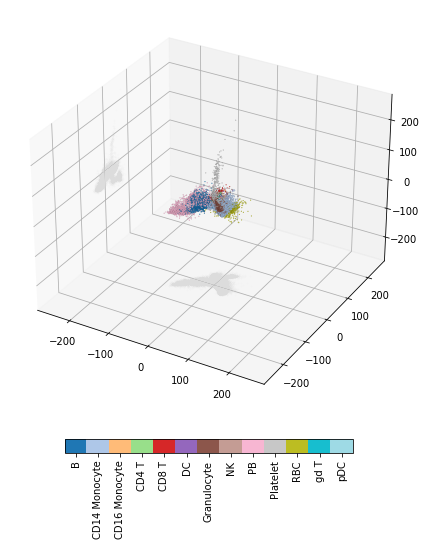

In [4]:
pymde.plot(scrna_wilk.data, color_by=scrna_wilk.attributes['cell_type'], color_map='tab20')

### Embedding

We'll compute an embedding via `pymde.preserve_neighbors`. We use this function, instead of `pymde.preserve_distances`, because we're interested more in the local structure of the data than the global.
The exact distance between transcriptomes does not matter much, and might not even be that reliable.

In the below cell, we've chosen to compute a standardized embedding. Standardized embeddings are generally reasonable: the constraint prevents the vectors from spreading out too much, and enforces the feature columns of the embedding to be uncorrelated.

Feel free to experiment with the keyword arguments of the `preserve_neighbors` function. For example, you can omit the constraint (replace it with `None`), vary the `repulsive_fraction` or the number of neighbors `n_neighbors`, try a random initialization (`init='random'`), or modify the attractive and repulsive penalties.

For a full list of the configurable options, type `pymde.preserve_neighbors?` into a code cell, and execute it.

In [5]:
mde = pymde.preserve_neighbors(
    scrna_wilk.data,
    embedding_dim=3,
    constraint=pymde.Standardized(),
    repulsive_fraction=1.0,
    verbose=True,
)
embedding = mde.embed(verbose=True)

Feb 04 08:57:19 AM: Constructing kNN graph (k=15)
Thu Feb  4 08:57:27 2021 Building RP forest with 20 trees
Thu Feb  4 08:57:27 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Feb 04 08:57:38 AM: Computing quadratic initialization.
Feb 04 08:57:45 AM: Fitting a standardized embedding into R^3, for a graph with 44721 items and 1030669 edges.
Feb 04 08:57:45 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Feb 04 08:57:45 AM: iteration 000 | distortion 0.355477 | residual norm 0.0163964 | step length 0.395492 | percent change 0.00177041
Feb 04 08:57:48 AM: iteration 030 | distortion 0.159885 | residual norm 0.000365334 | step length 1 | percent change 5.30764
Feb 04 08:57:50 AM: iteration 060 | distortion 0.147308 | residual norm 0.000179263 | step length 1 | percent change 1.74398
Feb 04 08:57:53 AM: iteration 090 | distortion 0.145413 | residual norm 7.43528e-05 | step length 1 | percent ch

Next, we plot the embedding.

Because the embedding is in 3 dimensions, some viewing angles look better than others. You can use `pymde.rotate` to rotate the embedding until you find a good angle.

(Alternatively, use external libraries like Polyscope to explore 3D embeddings interactively.)

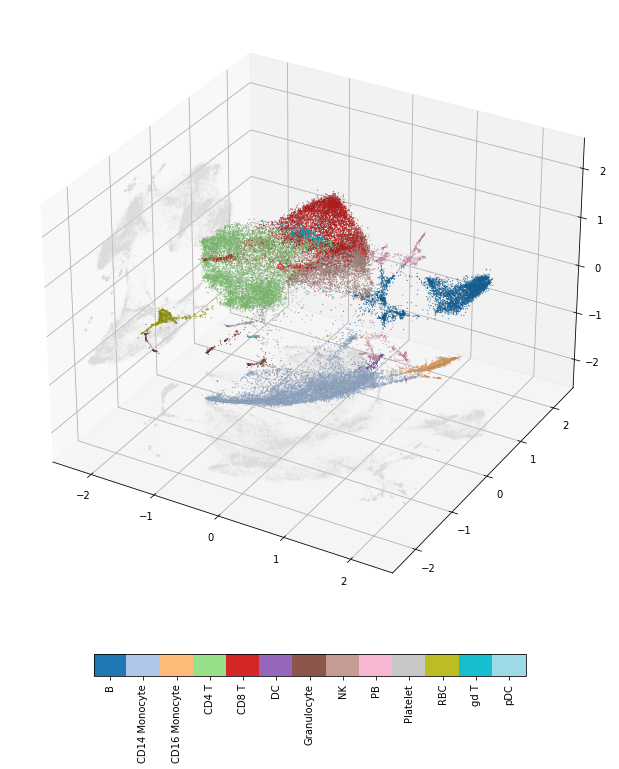

In [6]:
angles = torch.tensor([50., 167., 225.])
rotated_embedding = pymde.rotate(embedding, angles)
pymde.plot(rotated_embedding, color_by=scrna_wilk.attributes['cell_type'], color_map='tab20',
           figsize_inches=(12, 12))

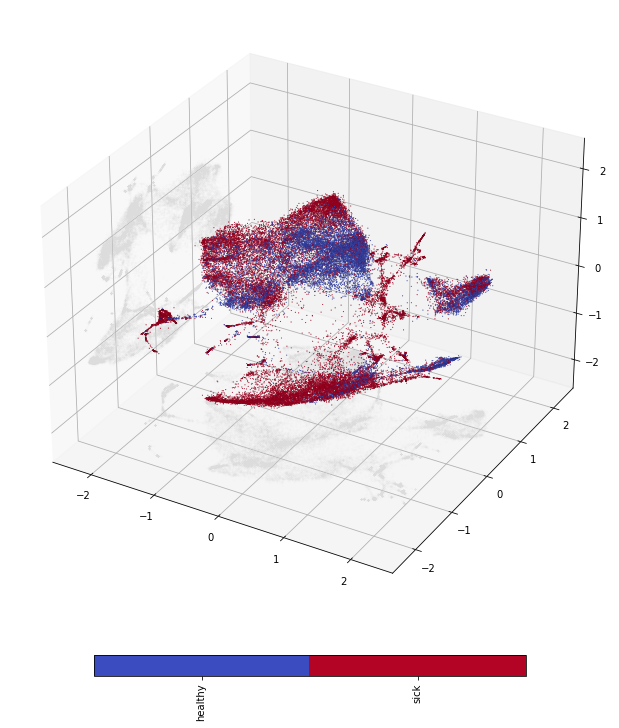

In [7]:
pymde.plot(rotated_embedding, color_by=scrna_wilk.attributes['health_status'], color_map='coolwarm',
           figsize_inches=(12, 12))

Below, we plot a random sample of edges between pairs of similar cells. You'll see that the edges trace out the clusters in the embedding, and that different clusters are loosely connected to each other.

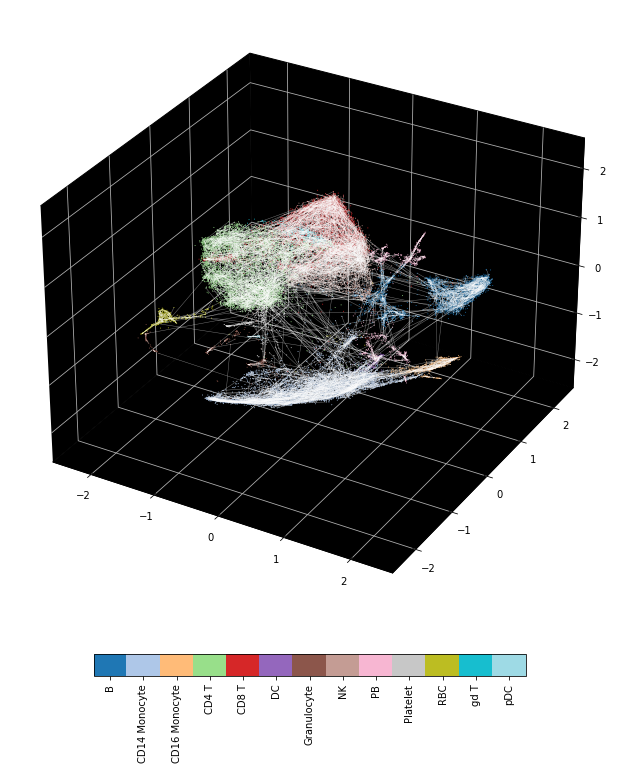

In [8]:
import torch

similar_cells = mde.edges[mde.distortion_function.pos_idx]
sampled_edges = similar_cells[torch.randperm(similar_cells.shape[0])[:10000]]
pymde.plot(rotated_embedding, color_by=scrna_wilk.attributes['cell_type'], color_map='tab20',
           edges=sampled_edges, figsize_inches=(12, 12))

In the next cell, we plot the 500 pairs of cells that experienced the largest distortion. These represent pairs of cells that were difficult to embed.

In general, it can be instructive to manually inspect the original data corresponding to the most highly distorted pairs. You might find that the pairs don't actually represent similar items (cells), or maybe that the items are in some way outliers, anomalous, or corrupted.

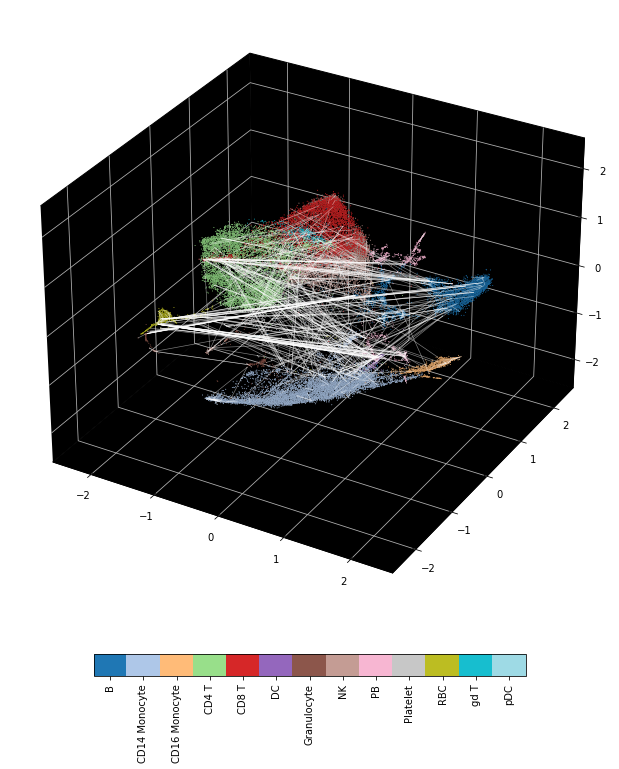

In [9]:
pairs, _ = mde.high_distortion_pairs()
most_distorted_pairs = pairs[:500]
pymde.plot(rotated_embedding, color_by=scrna_wilk.attributes['cell_type'], color_map='tab20',
           edges=most_distorted_pairs, figsize_inches=(12, 12))

Finally, we plot the CDF of distortions below. You can see that most cells experience little distortions, but a few cells --- roughly 10 or 20 percent --- have much higher distortion.

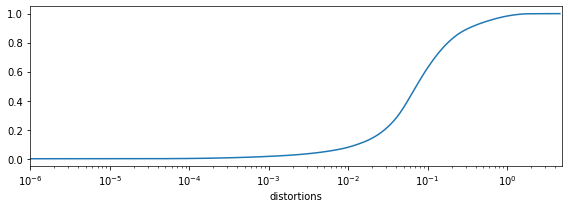

In [10]:
mde.distortions_cdf()

In this notebook, we computed a neighbor-preserving embedding, since we were more interested in the local structure than the global structure of the data.

If you are curious what a distance-preserving embedding might look like, you can compute one using the following code:

```python3

mde = pymde.preserve_distances(
    scrna_wilk.data,
    embedding_dim=3,
    verbose=True,
    max_distances=1e7,
)
embedding = mde.embed(verbose=True)
```

You'll find that it looks similar to the original PCA embedding.